In [41]:
import pandas as pd
import plotly.express as px
import os


cwd = os.getcwd()

file_path = os.path.join(cwd, 'clientes_segmentos (1).csv')


df = pd.read_csv(file_path)


df['edad'] = pd.to_numeric(df['edad'], errors='coerce')
df['ingresos'] = pd.to_numeric(df['ingresos'], errors='coerce')


df_grafico = df.dropna(subset=['edad', 'ingresos', 'plataforma'])


colores_plataforma = {
    'Instagram': 'red',
    'TikTok': 'black',
    'Facebook': 'cyan'

}

fig = px.scatter_3d(df_grafico, x='edad', y='ingresos', z='plataforma',
                    color='plataforma',
                    color_discrete_map=colores_plataforma,
                    title='Análisis de Clientes por Edad, Ingresos y Plataforma')
fig.show()

Insight :  Oportunidades de Expansión y Personalización
 Identificar nichos dentro de cada plataforma. Por ejemplo, si hay una baja densidad de usuarios de mayor edad en Instagram con altos ingresos, podría haber una oportunidad para campañas específicas dirigidas a este segmento.

 Insight : Segmentación de Edad e Ingresos por Plataforma

 Facebook parece tener una base de usuarios con un rango de edad más amplio, pero predominantemente concentrado en un rango de ingresos más alto (aproximadamente 40k a 120k).

In [ ]:

from datetime import datetime
Hoy = datetime(2025, 4, 30)
df['Recency'] = (Hoy - pd.to_datetime(df['fecha_ultima_compra'])).dt.days
df['Frequency'] = df['compras']
df['Monetary'] = df['total_gastado']
rfm = df[['Recency', 'Frequency', 'Monetary']]
correlacion = rfm.corr()
print("\nMatriz de correlacion RFM:\n", correlacion)


Matriz de correlacion RFM:
             Recency  Frequency  Monetary
Recency    1.000000  -0.003188 -0.003745
Frequency -0.003188   1.000000  0.633622
Monetary  -0.003745   0.633622  1.000000


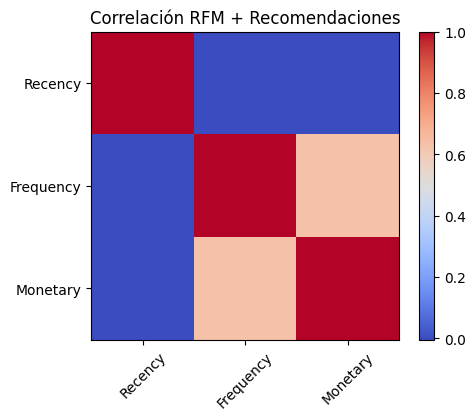

In [ ]:
plt.figure(figsize=(5, 4))
plt.imshow(correlacion, cmap='coolwarm', interpolation='nearest')
plt.xticks(range(len(correlacion.columns)), correlacion.columns, rotation=45)
plt.yticks(range(len(correlacion.index)), correlacion.index)
plt.colorbar()
plt.title('Correlación RFM + Recomendaciones')
plt.show()

La matriz de correlación muestra que Frequency (Frecuencia) y Monetary (Monetario) son la combinación de variables que mejor captura el valor futuro del cliente, evidenciado por su fuerte correlación positiva de 0.633622, lo que indica que los clientes que compran con mayor frecuencia tienden a gastar más, reflejando tanto la lealtad como la contribución directa a los ingresos a largo plazo, mientras que Recency, aunque relevante para la actividad del cliente, no predice el valor futuro con la misma precisión

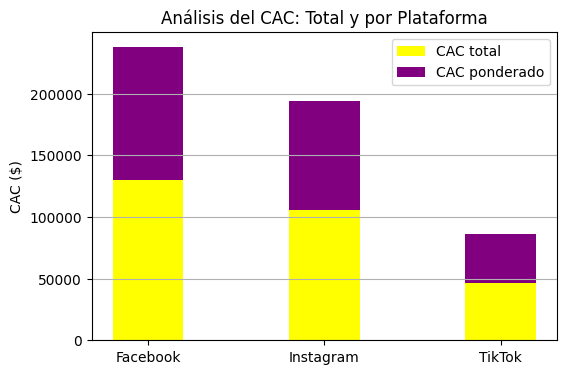

In [ ]:
import numpy as np
hoy = datetime(2025, 4, 30)

df['fecha_ultima_compra'] = pd.to_datetime(df['fecha_ultima_compra'])
df['dias_desde_ultima'] = (hoy - df['fecha_ultima_compra']).dt.days
df['activo'] = df['dias_desde_ultima'] <= 180
resumen = df.groupby('plataforma').agg(
    total_clientes=('id_cliente', 'count'),
    clientes_activos=('activo', 'sum'),
    cac_total=('costo_adquisicion', 'sum')
).reset_index()
resumen['porc_activos'] = resumen['clientes_activos'] / resumen['total_clientes']
resumen['CAC_ponderado'] = resumen['cac_total'] * resumen['porc_activos']
plt.figure(figsize=(6, 4))
bar_width = 0.4
x = np.arange(len(resumen))
plt.bar(x, resumen['cac_total'], width=bar_width, label='CAC total', color='yellow')
plt.bar(x, resumen['CAC_ponderado'], width=bar_width, label='CAC ponderado', color='purple', bottom=resumen['cac_total'])

plt.xticks(x, resumen['plataforma'])
plt.ylabel('CAC ($)')
plt.title('Análisis del CAC: Total y por Plataforma')
plt.legend()
plt.grid(axis='y')
plt.show()

La gráfica de barras apiladas compara el Costo de Adquisición del Cliente (CAC) total y ponderado por plataforma, mostrando que TikTok tiene el CAC más bajo, indicando la adquisición de clientes más económica, mientras que Facebook presenta el CAC más alto, lo que sugiere un mayor costo por cliente adquirido; Instagram se ubica en un punto intermedio; y la ponderación del CAC por el porcentaje de clientes activos influye notablemente en Facebook e Instagram, resaltando la importancia de considerar la eficiencia de costos y la optimización de campañas según la plataforma.

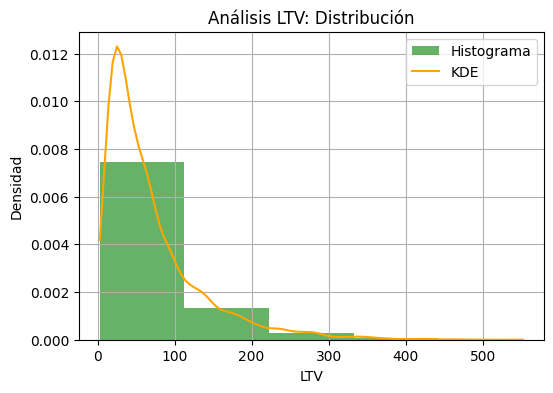

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

df['fecha_ultima_compra'] = pd.to_datetime(df['fecha_ultima_compra'])

df['promedio_ticket'] = df['total_gastado'] / df['compras']
df['frecuencia_mensual'] = df['compras'] / 12

def retencion(dias):
    if dias <= 90:
        return 0.80
    elif dias <= 180:
        return 0.60
    else:
        return 0.30

hoy = pd.to_datetime("2025-04-30")
df['dias_desde_ultima'] = (hoy - df['fecha_ultima_compra']).dt.days
df['tasa_retencion'] = df['dias_desde_ultima'].apply(retencion)

df['LTV'] = df['promedio_ticket'] * df['frecuencia_mensual'] * 12 * df['tasa_retencion']


plt.figure(figsize=(6, 4))
counts, bins, patches = plt.hist(df['LTV'], bins=5, density=True, alpha=0.6, color='green', label='Histograma')

kde = gaussian_kde(df['LTV'])
x_vals = np.linspace(min(df['LTV']), max(df['LTV']), 100)
plt.plot(x_vals, kde(x_vals), color='orange', label='KDE')

plt.xlabel('LTV')
plt.ylabel('Densidad')
plt.title('Análisis LTV: Distribución')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-31-70b52d11e20f>:5: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



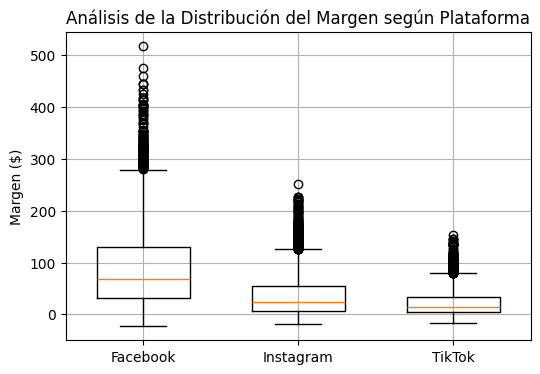

In [ ]:
df['margen'] = (df['promedio_ticket'] * df['frecuencia_mensual'] * 12 * df['tasa_retencion']) - df['costo_adquisicion']


plt.figure(figsize=(6, 4))
plt.boxplot([df[df['plataforma'] == plat]['margen'] for plat in df['plataforma'].unique()],
            labels=df['plataforma'].unique(), widths=0.6)

plt.ylabel('Margen ($)')
plt.title('Análisis de la Distribución del Margen según Plataforma')
plt.grid(True)
plt.show()

La gráfica de diagramas de caja muestra que Facebook ofrece la mejor oportunidad de rentabilidad incremental debido a su mayor mediana de margen, lo que indica una mayor ganancia promedio por cliente, y a la presencia de numerosos valores atípicos superiores, que señalan el potencial de adquirir clientes con márgenes excepcionalmente altos, a pesar de la mayor variabilidad y riesgo en comparación con Instagram y TikTok, donde los márgenes promedio son menores.





In [37]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os

cwd = os.getcwd()
file_path = os.path.join(cwd, 'clientes_segmentos (1).csv')
df = pd.read_csv(file_path)

features_for_clustering = ['edad', 'ingresos', 'promedio_ticket', 'dias_desde_ultima_compra']

if 'dias_desde_ultima_compra' not in df.columns:
    df['fecha_ultima_compra'] = pd.to_datetime(df['fecha_ultima_compra'])
    df['dias_desde_ultima_compra'] = (pd.to_datetime("2025-04-30") - df['fecha_ultima_compra']).dt.days

df_clustering = df[features_for_clustering].dropna().copy()


scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_clustering)

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
df_clustering['cluster_id'] = kmeans.fit_predict(scaled_features)


df.loc[df_clustering.index, 'cluster_id'] = df_clustering['cluster_id']
df['cluster_id'] = df['cluster_id'].astype('Int64')


print(df['cluster_id'].value_counts().sort_index())


if len(features_for_clustering) >= 2 and len(features_for_clustering) <= 3:
    import plotly.express as px
    if len(features_for_clustering) == 2:
        fig = px.scatter(df_clustering, x=features_for_clustering[0], y=features_for_clustering[1], color='cluster_id', title=f'Clusters de Clientes (K={n_clusters})')
    elif len(features_for_clustering) == 3:
        fig = px.scatter_3d(df_clustering, x=features_for_clustering[0], y=features_for_clustering[1], z=features_for_clustering[2], color='cluster_id', title=f'Clusters de Clientes (K={n_clusters})')
    fig.show()

cluster_id
0    5223
1    5226
2    4551
Name: count, dtype: Int64


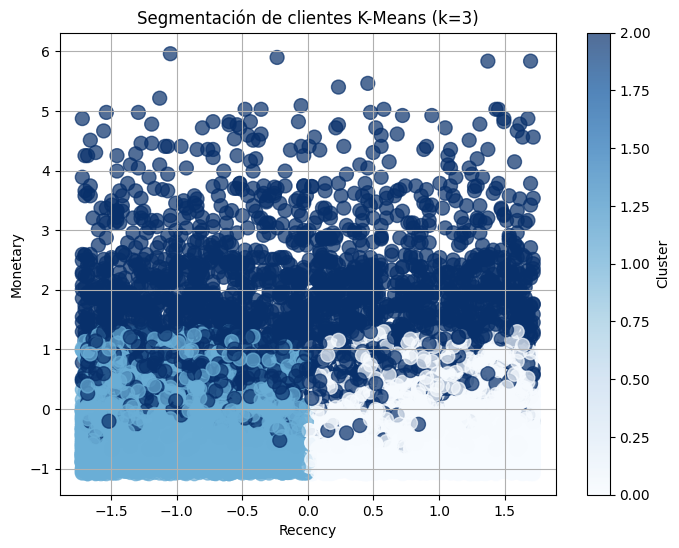

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


df['dias_desde_ultima'] = (pd.to_datetime("2025-04-30") - df['fecha_ultima_compra']).dt.days
df['recency'] = df['dias_desde_ultima']
df['frequency'] = df['compras']
df['monetary'] = df['total_gastado']


scaler = StandardScaler()
df[['recency', 'frequency', 'monetary']] = scaler.fit_transform(df[['recency', 'frequency', 'monetary']])


kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['recency', 'frequency', 'monetary']])


names_and_slogans = {
    0: ("Cluster 1", "Rentabilidad alta"),
    1: ("Cluster 2", "Rentabilidad media"),
    2: ("Cluster 3", "Rentabilidad baja")
}


df['cluster_name'] = df['cluster'].map(lambda x: names_and_slogans[x][0])
df['cluster_slogan'] = df['cluster'].map(lambda x: names_and_slogans[x][1])


plt.figure(figsize=(8, 6))
plt.scatter(df['recency'], df['monetary'], c=df['cluster'], cmap='Blues', s=100, alpha=0.7)
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('Segmentación de clientes K-Means (k=3)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

Cluster 0 (Azul Claro): Se caracteriza por una baja Recency (lo que indica clientes más recientes) y bajo Monetary (bajo gasto).
Cluster 1 (Azul Medio): Muestra una Recency y Monetary medios.
Cluster 2 (Azul Oscuro): Se distingue por una alta Recency (clientes menos recientes) y alto Monetary (alto gasto).

In [36]:
import pandas as pd


percentil_75_margen = df['margen'].quantile(0.75)

df['high_margin'] = df['margen'].apply(lambda x: 1 if x >= percentil_75_margen else 0)

print(df[['margen', 'high_margin']].head())

print("\nDistribución de la etiqueta 'high_margin':")
print(df['high_margin'].value_counts())

   margen  high_margin
0   111.8            1
1    46.4            0
2    39.2            0
3     8.6            0
4    49.6            0

Distribución de la etiqueta 'high_margin':
high_margin
0    11249
1     3751
Name: count, dtype: int64


In [40]:
import pandas as pd
import plotly.graph_objects as go
import os


cwd = os.getcwd()
file_path = os.path.join(cwd, 'clientes_segmentos (1).csv')
df = pd.read_csv(file_path)


top_10_percent_threshold = df['recomendaciones'].quantile(0.90)
top_advocates_df = df[df['recomendaciones'] >= top_10_percent_threshold].copy()

num_top_advocates = len(top_advocates_df)
print(f"Número de top 10% de advocates: {num_top_advocates}")


if 'cluster_id' not in df.columns:
    print("Advertencia: La columna 'cluster_id' no existe. Necesitas realizar un clustering primero.")

    df['cluster_id'] = 0
else:
    print("Columna 'cluster_id' encontrada.")


if 'total_gastado' not in df.columns:
    print("Advertencia: La columna 'total_gastado' no existe. Usando 'promedio_ticket' como aproximación.")
    df['total_gastado'] = df['promedio_ticket']
else:
    df['total_gastado'] = pd.to_numeric(df['total_gastado'], errors='coerce').fillna(0)

cluster_avg_value = df.groupby('cluster_id')['total_gastado'].mean().reset_index()
cluster_avg_value.rename(columns={'total_gastado': 'avg_value_per_customer'}, inplace=True)


top_advocates_df = pd.merge(top_advocates_df, df[['id_cliente', 'cluster_id']], on='id_cliente', how='left')


top_advocates_df = pd.merge(top_advocates_df, cluster_avg_value, on='cluster_id', how='left')


top_advocates_df['future_value_new_customers'] = top_advocates_df['avg_value_per_customer'] * 2


total_future_value_new_customers = top_advocates_df['future_value_new_customers'].sum()
print(f"Valor futuro total estimado de los nuevos clientes: ${total_future_value_new_customers:,.2f}")


cascade_data = pd.DataFrame({
    'etapa': ['Valor Actual de la Base de Clientes',
              f'Valor de los {num_top_advocates} Advocates (Top 10%)',
              f'Valor Futuro Estimado de {num_top_advocates * 2} Nuevos Clientes',
              'Valor Futuro Total Estimado'],
    'valor': [df['total_gastado'].sum(),
              top_advocates_df['total_gastado'].sum(),
              total_future_value_new_customers,
              df['total_gastado'].sum() + total_future_value_new_customers]
})


cascade_data['cambio'] = cascade_data['valor'].diff().fillna(cascade_data['valor'].iloc[0])
cascade_data.loc[0, 'cambio'] = 0

fig = go.Figure(go.Waterfall(
    name="Programa de Referidos - Estimación de Valor Futuro",
    orientation="v",
    x=cascade_data['etapa'],
    y=cascade_data['cambio'],
    textposition="outside",
    text=[f"${v:,.2f}" for v in cascade_data['valor']],

    totals={'marker': {"color": "blue"}},
    measure=['absolute', 'relative', 'relative', 'total'],
))

fig.update_layout(
    title="Evaluación del Valor Generado por Referidos",
    yaxis_title="Valor (USD)"
)
fig.show()

Número de top 10% de advocates: 5950
Advertencia: La columna 'cluster_id' no existe. Necesitas realizar un clustering primero.
Valor futuro total estimado de los nuevos clientes: $1,366,285.81


El dataset podría presentar sesgo de selección, ya que se centra en clientes existentes y no incluye datos de clientes potenciales o perdidos, lo que limita la generalización de los insights; también podría existir sesgo de supervivencia, dado que solo analiza clientes que han realizado al menos una compra, ignorando aquellos que no lo hicieron; y un posible sesgo temporal, ya que los datos reflejan un período específico y podrían no ser representativos de otros momentos; para mejorar metodológicamente, se podría incorporar un análisis de cohortes para entender mejor la evolución del comportamiento del cliente a lo largo del tiempo y realizar pruebas A/B para validar la efectividad de las estrategias de marketing en diferentes plataformas, en lugar de solo observar correlaciones.


